In [1]:
import os
import json
from tqdm import tqdm
import numpy as np
import cv2

from PIL import Image
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection


In [2]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").cuda()


In [3]:
with open("../../vg_region_processor/region_graphs.json", "r") as h:
    data = json.load(h)

In [4]:
with open("../../vg_region_processor/image_data.json", "r") as h:
    image_data = json.load(h)
image_size = {}
for d in image_data:
    image_size[d['image_id']] = (d['height'], d['width'])

In [5]:
id2path = {}
for fname in os.listdir("../../vg_region_processor/data/VG_100K"):
    id2path[int(fname.split('.')[0])] = os.path.join("../../vg_region_processor/data/VG_100K", fname)
for fname in os.listdir("../../vg_region_processor/data/VG_100K_2"):
    id2path[int(fname.split('.')[0])] = os.path.join("../../vg_region_processor/data/VG_100K_2", fname)

In [6]:
total_owlvit_steps = 0
for rgraph in tqdm(data):
    if rgraph['image_id'] not in id2path:
        continue
    h,w = image_size[rgraph['image_id']]
    H,W = 64,64
    for region in rgraph['regions']:
        if len(region['relationships'])==0:
            continue
        total_owlvit_steps+=1

100%|███████████████████████████████████████████████████████████████████████████████████████| 108077/108077 [00:02<00:00, 53375.08it/s]


In [7]:
## maximum possible owlvit steps without post-processing
total_owlvit_steps

1924201

In [8]:
# pickle file for each image
# {
#     "image_id": ID,
#     "owlvit": {"object_name": [bbox1, bbox2, etc.]},
#     "regions": [
#         {"phrase": "text", "nouns": ["w1", "w2"], "region_mask": []}
#     ]
# }

In [9]:
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()

In [10]:
all_vg_processed_data = []

for rgraph in tqdm(data):
    if rgraph['image_id'] not in id2path:
        continue

    image_data_to_store = {
        "image_id": rgraph['image_id'],
        "regions": [],
        "nouns": set(),
    }
    h,w = image_size[rgraph['image_id']]
    H,W = 64,64
    for region in rgraph['regions']:
        if len(region['relationships'])==0:
            continue

        region_image = np.zeros((H, W, 3))
        y1 = int(region['y']*H/h)
        y2 = int(y1+(region['height']*H/h))
        x1 = int(region['x']*W/w)
        x2 = int(x1+(region['width']*W/w))
        region_image[y1:y2, x1:x2] = 1.0
        # region_image = cv2.rectangle(region_image, (x1, y1), (x2, y2), (255, 255, 255), 1)
        if region_image[:,:,0].sum()<4.0:
            continue
            
        doc = nlp(region['phrase'])
        bbox_phrases_uft = [w.text for w in doc if w.pos_=="NOUN"]
        image_data_to_store["regions"].append({"phrase": region["phrase"], "nouns": bbox_phrases_uft, "region_mask": region_image})
        for word in bbox_phrases_uft:
            image_data_to_store["nouns"].add(word)

    if len(list(image_data_to_store["nouns"]))==0:
        continue
    
    with torch.no_grad():
        try:
            image = Image.open(id2path[rgraph['image_id']])
            texts = [[f"a photo of a {w}" for w in image_data_to_store["nouns"]]]
            inputs = processor(text=texts, images=image, return_tensors="pt")
        except:
            continue
        inputs = {k:v.cuda() for k,v in inputs.items()}
        outputs = model(**inputs)
        target_sizes = torch.Tensor([image.size[::-1]]).cuda()
        results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
        
    
    tmp_data = {}
    i = 0  # Retrieve predictions for the first image for the corresponding text queries
    text = texts[i]
    boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
    for box, score, label in zip(boxes, scores, labels):
        box = [round(i, 2) for i in box.tolist()]
        # print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")
        x1 = np.clip(int(box[0]*W/w), 0, W)
        x2 = np.clip(int(box[2]*W/w), 0, W)
        y1 = np.clip(int(box[1]*H/h), 0, H)
        y2 = np.clip(int(box[3]*H/h), 0, H)
    
        if list(image_data_to_store["nouns"])[label] not in tmp_data:
            tmp_data[list(image_data_to_store["nouns"])[label]] = []
        tmp_data[list(image_data_to_store["nouns"])[label]].append([x1,y1,x2,y2])

    image_data_to_store["owlvit"] = tmp_data
    torch.cuda.empty_cache()

    ## store the pickle file
    all_vg_processed_data.append(image_data_to_store)
    

100%|████████████████████████████████████████████████████████████████████████████████████████| 108077/108077 [5:20:24<00:00,  5.62it/s]


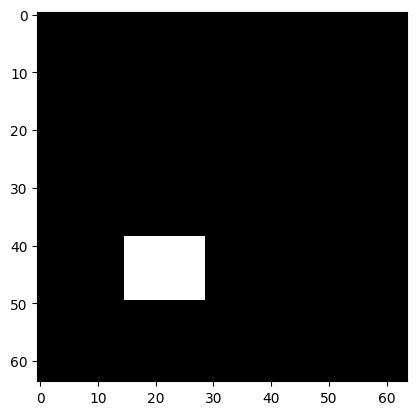

In [15]:
import matplotlib.pyplot as plt

plt.imshow(all_vg_processed_data[0]['regions'][0]['region_mask'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


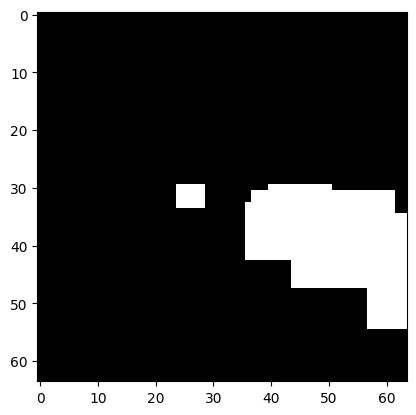

In [18]:
mask_image = np.zeros((64, 64, 3))

for (x1,y1,x2,y2) in all_vg_processed_data[0]['owlvit']['car']:
    mask_image[y1:y2, x1:x2] = 255

plt.imshow(mask_image)

In [14]:
all_vg_processed_data[0]

{'image_id': 1,
 'regions': [{'phrase': 'shade is along the street ',
   'nouns': ['shade', 'street'],
   'region_mask': array([[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
   
          ...,
   
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
   
        

In [11]:
import pickle

with open("./vg_owlvit_regions_v2.pkl", "wb") as h:
    pickle.dump(all_vg_processed_data, h)